In [11]:
%matplotlib inline
# Import libraries
import pandas as pd
import numpy as np
import pylab as P
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [12]:
# Load Data
df = pd.read_csv('train.csv', header=0)
print(df.info())

# PassengerId
# Survived
# Pclass
# Name
# Sex
# Age
# SibSp
# Parch
# Ticket
# Fare
# Cabin
# Embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [13]:
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# We dropped the name, ticket and cabin because we don't consider that they have a true value
# in the prediction model. Name is really hard to enumerate, cabin have to many null values
# and we don't have enough information about ticket

# Sex enumerate as Gender
# Fix null values of age
# Fix null values of embarked

In [14]:
# Numeralize Sex as female = 0 and male = 1
df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [15]:
# Fix empty values for age based on PClass and Gender
median_ages = np.zeros((2,3))

for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df[(df['Gender'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()

# print median_ages
        
df['AgeFill'] = df['Age']

for i in range(0, 2):
    for j in range(0, 3):
        df.loc[(df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1),'AgeFill'] = median_ages[i,j]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
Gender         891 non-null int32
AgeFill        891 non-null float64
dtypes: float64(3), int32(1), int64(5), object(2)
memory usage: 73.2+ KB
None


In [16]:
df[(df['PassengerId'] == 62) | (df['PassengerId'] == 830)]
# The two passengers without information about embarked have a passenger class 1 with a fare
# of 80.0

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Gender,AgeFill
61,62,1,1,female,38.0,0,0,80.0,NaN,0,38.0
829,830,1,1,female,62.0,0,0,80.0,NaN,0,62.0


In [17]:
# Fix Empty values in data set for Embarked and numeralize as 'C' = 0, 'Q' = 1, 'S': 2
embarked_categories = df['Embarked'].unique()
embarked_frequencies = np.zeros((2,3,len(embarked_categories)-1))
embarked_fares = np.zeros((3, len(embarked_categories)-1))

for i in range(1, 4):
    for j in range(0, len(embarked_categories)-1):
        embarked_fares[i-1, j] = df[(df['Pclass'] == i) &
                                    (df['PassengerId'] != 62) &
                                    (df['PassengerId'] != 830) &
                                    (df['Embarked'] == embarked_categories[j])
                                   ]['Fare'].median()
print(embarked_categories)
print(embarked_fares)

# Based on the median of the embarked_fares, we can say that the two passengers that payed
# for a class 1 with 80 of fare should have been embarked from the 'C' port

df['EmbarkedFill'] = df['Embarked']
df.loc[(df['PassengerId'] == 62), 'EmbarkedFill'] = 'C'
df.loc[(df['PassengerId'] == 830), 'EmbarkedFill'] = 'C'
df['Port'] = df['EmbarkedFill'].map( {'C': 0, 'Q': 1, 'S': 2} ).astype(int)

['S' 'C' 'Q' nan]
[[ 52.      78.2667  90.    ]
 [ 13.5     24.      12.35  ]
 [  8.05     7.8958   7.75  ]]


# Sample the 70%-30% of the data

The sample is divided in 2 parts, train and test data, leave a copy of test (validation) for evaluation purposes

In [18]:
# For cabin with can't do too much, we don't know if the passengers with empty value 
# had no cabin or the value is missing

# divide the data between an train dataset and a test dataset

data_labels = ['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Gender', 'AgeFill', 'Port']
target_labels = ['PassengerId', 'Survived']

from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df[data_labels], df[target_labels], test_size=.3)

# Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

max_score = 0
best_n = 0

for n in range(1, 50):
    rf_score = 0
    model = RandomForestClassifier(n_estimators = n)
    model = model.fit(X_train.values[0:, 1:], Y_train.values[0:, 1])
    rf_score = model.score(X_test.values[0:, 1:], Y_test.values[0:, 1])
    
    if rf_score > max_score:
        max_score = rf_score
        best_n = n

print(best_n, max_score)

26 0.839552238806


In [21]:
from sklearn.ensemble import RandomForestClassifier

max_score = 0
best_depth = 0

for n in range(1, 100):
    rf_score = 0
    model = RandomForestClassifier(max_depth=n)
    model = model.fit(X_train.values[0:, 1:], Y_train.values[0:, 1])
    rf_score = model.score(X_test.values[0:, 1:], Y_test.values[0:, 1])
    
    if rf_score > max_score:
        max_score = rf_score
        best_depth = n
        
print(best_depth, max_score)

28 0.84328358209


0.809701492537
[[129  25]
 [ 26  88]]
[ 0.          0.16233766  1.        ] [ 0.          0.77192982  1.        ] 0.804796081112


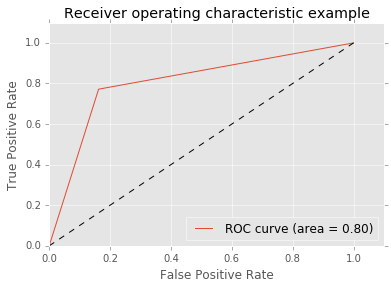

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

best_n = 26
best_depth = 28

model = RandomForestClassifier(n_estimators=best_n, max_depth=best_depth)
model = model.fit(X_train.values[0:, 1:], Y_train.values[0:, 1])
output = model.predict(X_test.values[0:, 1:])
prob_output = model.predict_proba(X_test.values[0:, 1:])
rf_score = model.score(X_test.values[0:, 1:], Y_test.values[0:, 1])

rf_cm = confusion_matrix(Y_test.values[0:, 1], output.astype(int))
print(rf_score)
print(rf_cm)

fpr, tpr, _ = roc_curve(Y_test.values[0:, 1], output.astype(int))
roc_auc = auc(fpr, tpr)
print(fpr, tpr, roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# Naive Bayes GaussianNB

In [59]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

model = GaussianNB()
model = model.fit(X_train.values[0:, 1:], Y_train.values[0:, 1])
output = model.predict(X_test.values[0:, 1:])
gnb_score = model.score(X_test.values[0:, 1:], Y_test.values[0:, 1])

gnb_cm = confusion_matrix(Y_test.values[0:, 1], output.astype(int))
print gnb_score
print gnb_cm

0.791044776119
[[145  24]
 [ 32  67]]


# Naive Bayes MultinomialNB

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

model = MultinomialNB()
model = model.fit(X_train.values[0:, 1:], Y_train.values[0:, 1])
output = model.predict(X_test.values[0:, 1:])
mnb_score = model.score(X_test.values[0:, 1:], Y_test.values[0:, 1])

mnb_cm = confusion_matrix(Y_test.values[0:, 1], output.astype(int))
print mnb_score
print mnb_cm

0.664179104478
[[136  33]
 [ 57  42]]


# Naive Bayes Bernoulli

In [57]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

model = BernoulliNB()
model = model.fit(X_train.values[0:, 1:], Y_train.values[0:, 1])
output = model.predict(X_test.values[0:, 1:])
bnb_score = model.score(X_test.values[0:, 1:], Y_test.values[0:, 1])


bnb_cm = confusion_matrix(Y_test.values[0:, 1], output.astype(int))
print bnb_score
print bnb_cm

0.757462686567
[[142  27]
 [ 38  61]]
